In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Spectral'

In [2]:
def sigmoid(z) :
    """
    Returns the sigmoid function of the given input
    """
    return 1 /(1 + np.exp(-z))

def sigmoid_prime(z) :
    """
    Returns the derivative of the sigmoid function of the given input
    """
    return sigmoid(z)*(1-sigmoid(z))

def fp(x, eps):
    """
    Returns the value the SReLU takes in the interval -eps to eps
    
    The polynomial satifies the following conditions:
    fp(eps) = eps
    fp'(eps) = 1
    fp(-eps) = 0
    fp'(-eps) = 0
    
    """
    a_0 = eps/4
    a_1 = 0.5
    a_2 = 1/(4*eps)
    a_3 = 0
    
    return  a_0 + a_1*x + a_2*x**2 + a_3*x**3 

def SReLU(x, eps):
    """
    Returns a smoothed ReLU function with parameter epsilon
    """
    return fp(x, eps)*(np.abs(x) < eps) + x*(x >= eps)


def fp_prime(x, eps):
    """
    Returns derivative of the fp(x) with respect to x
    """
    a_0 = eps/4
    a_1 = 0.5
    a_2 = 1/(4*eps)
    a_3 = 0
    
    return  a_1 + 2*a_2*x + 3*a_3*x**2 

def SReLU_prime(x,eps):
    """
    Returns the derivative of the smoothed ReLU function
    """
    return fp_prime(x, eps)*(np.abs(x) < eps) + 1*(x >= eps)

def relu(z): 
    """
    Returns the rectified linear unit applied to the given input 
    """
    return np.maximum(0,z)

def relu_prime(z) :
    """
    Returns the derivative of rectified linear unit applied to the given input 
    """
    return 1*(z>=0)

def SReLU_prime_wrt_eps(x,eps):
    """
    Returns the derivative of the SReLU function
    with respect to epsilon given the input and parameter eps
    """
    return (1/4-(x**2)/(4*eps**2))*(np.abs(x) < eps)

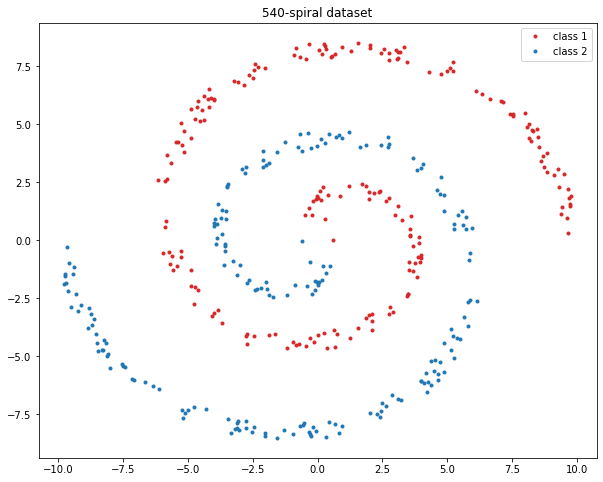

In [3]:
N = 200 # no. points per class
X = np.zeros((N*2,2))
y = np.zeros((N*2,1), dtype='uint8')

def twospirals(n_points, noise=0.75):
    """
     Returns the two spirals dataset.
    """
    np.random.seed(1)  # Random seed for data
    n = np.sqrt(np.random.rand(n_points,1)) * 540 * (2*np.pi)/360
    d1x = (- np.cos(n)*n + np.random.rand(n_points,1) * noise)
    d1y = (np.sin(n)*n + np.random.rand(n_points,1) * noise) 
    np.random.seed(None)  # Random seed for data
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.where(np.hstack((np.zeros(n_points),np.ones(n_points))) > 0.5, 1, 0))

X, y[:,0] = twospirals(N) # or choose number

plt.title('540-spiral dataset')
plt.plot(X[y[:,0]==0,0], X[y[:,0]==0,1], color='tab:red', marker='.', linestyle='None',label='class 1')
plt.plot(X[y[:,0]==1,0], X[y[:,0]==1,1], color='tab:blue', marker='.', linestyle='None', label='class 2')
plt.legend()
plt.show()

In [4]:
def plotboundary_accuracy(X, y, W1, b1, W2, b2):
    """
    Returns the accuracy for the given parameters and plots the decision boundary of the data
    """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),np.arange(y_min, y_max, 0.02))
    Z_axis = sigmoid(np.dot(relu(np.dot(np.c_[xx.ravel(), yy.ravel()], W1) + b1), W2) + b2)
    Z_axis = (Z_axis > 0.5)
    Z_axis = Z_axis.reshape(xx.shape)
    plt.contourf(xx, yy, Z_axis, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y[:,0], s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [5]:
def initialize_parameters(n_x,n_y,n_h):
    """
     Initialization of the weights and biases for the neural network
     n_x: number of inputs nodes
     n_y: number of output nodes
     n_h: number of hidden nodes
    """
    W1 = 1.0 * np.random.randn(n_x,n_h)/np.sqrt(n_x)  # [n_x, n_h ]
    b1 = np.zeros((1,n_h))              # [1, n_h ]
    W2 = 1.0 * np.random.randn(n_h,n_y)/np.sqrt(n_y) # [n_h, n_y ]
    b2 = np.zeros((1,n_y))              # [1, n_y ]
    
    return W1, b1, W2, b2   # Return initalise weights and biases

In [6]:
def forward_prop(X, W1, b1, W2, b2):
    """
     Return the parameters after one foward pass 
     N: Number of points per class
     X: dimension [2N, n_x]
     n_x: number of inputs nodes
     n_y: number of output nodes
     n_h: number of hidden nodes
     
    """
    Z1 = np.dot(X, W1) + b1   # [2N, n_h]
    A1 = relu(Z1) # [2N, n_h]
    Z2 = np.dot(A1, W2) + b2  # [2N, n_y]
    A2 = sigmoid(Z2)          # [2N, n_y]
    
    return Z1, A1, Z2, A2

In [7]:
def cost(Y, A2):
    """
    Returns the L2 error between the predicted values 
    by the network A2 and the actual values of the data Y
    """
    m = Y.shape[0]
    return np.sum(np.square(A2-Y))/m

In [8]:
def back_prop(X,y, Z1, A1, Z2, A2, reg):
    """
     Return the gradient of parameters with respect to the loss after one foward pass 
     reg: regularisation parameter
     eps: smoothed ReLU parameter epsilon
     N: Number of points per class
     X: dimension [2N, n_x]
     n_x: number of inputs nodes
     n_y: number of output nodes
     n_h: number of hidden nodes
     """
    
    m = X.shape[0]                # Number of data points in total, 2N
    
    dZ2 = 2*(A2 - y)/m              # Derivative of cross-entropy loss is (A2-y), [m,1]
    dZ2 = dZ2*sigmoid_prime(Z2)   # Derivative with respect to Z2, [m,1]

    dW2 = np.dot(A1.T, dZ2)                     # Derivative with respect to W2, [n_h, n_y ]
    db2 = np.sum(dZ2, axis=0, keepdims=True)    # Derivative with respect to b2, [1, n_y ]

    dA1 = np.dot(dZ2, W2.T)                             # Derivative with respect to A1, [m, n_h]
    dZ1 = np.multiply(dA1, relu_prime(Z1))  # Derivative with respect to Z1, [m, n_h]
    
    dW1 = np.dot(X.T, dZ1)                   # Derivative with respect to W1, [n_x, n_h]
    db1 = np.sum(dZ1, axis=0, keepdims=True) # Derivative with respect to b1, [1, n_h]

    dW2 = dW2 + reg * W2 # regularisation of weight W2
    dW1 = dW1 + reg * W1 # regularisation of weight W1

    return dW1, db1, dW2, db2

In [9]:
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    """
    Returns the updated values of the parameters 
    after the given interation 
    """
    
    W1 = W1 - dW1 * learning_rate
    b1 = b1 - db1 * learning_rate
    W2 = W2 - dW2 * learning_rate
    b2 = b2 - db2 * learning_rate
    
    return W1, b1, W2, b2

In [10]:
C = X.shape[0]
np.random.seed(5)
# You need to shuffle the data in order to get blue and red points in all the sets
perm = np.random.permutation(len(X)) # This allows us to shuffle data without losing the labels on the y-vector
X_shuffle= X[perm]
y_shuffle = y[perm]

# We define a size for train set
train_index = int(0.7*C)
# And for validation set

In [11]:
# Create sets, same method as for SGD
X_train, y_train = X_shuffle[:train_index,:], y_shuffle[:train_index] 
X_test, y_test = X_shuffle[train_index:,:], y_shuffle[train_index:]

In [12]:
# Setting parameters
epochs = 20000
learning_rate = 0.2
runs = 100
reg = 1e-3

## GD

In [13]:
accuracy_train = np.zeros(runs)
accuracy_test = np.zeros(runs)
    
losses_train = np.zeros(runs)
losses_test =  np.zeros(runs)
    
for n in range(runs):
    n_h = 11
    n_x = 2
    n_y = 1
    
    W1, b1, W2, b2 = initialize_parameters(2,1,n_h)
        
    for i in range(epochs):
    
        Z1, A1, Z2, A2 = forward_prop(X_train, W1, b1, W2, b2)
            
        dW1, db1, dW2, db2 = back_prop(X_train, y_train, Z1, A1, Z2, A2, reg)
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
            
    pc_train = sigmoid(np.dot(relu(np.dot(X_train, W1) + b1), W2) + b2)
    accuracy_train[n] = (100*np.mean((pc_train >0.5) == y_train)) 
    pc_test =sigmoid(np.dot(relu(np.dot(X_test, W1) + b1), W2) + b2)
    accuracy_test[n] = (100*np.mean((pc_test >0.5) == y_test))
    
    reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)
    losses_train[n] = cost(y_train, pc_train) + reg_loss  # We only care about the last loss of the training 
    losses_test[n] =  cost(y_test, pc_test) + reg_loss  # We only care about the last loss of the training 
    

In [14]:
print('Gradient Descent')
print('Epochs: %.0f' % epochs)
print('Number of neurons: %.0f' % n_h)
print('Learning rate: %.2f' % learning_rate)
print('Final Mean Accuracy: %.2f %%' % np.mean(accuracy_test))
print('Final Accuracy std: %.2f %%' % np.std(accuracy_test))
print('Final Mean loss: %.2f' % np.mean(losses_test))
print('Final loss std: %.2f' %  np.std(losses_test))

85.425
